# Make a python version of http://ned.ipac.caltech.edu/forms/denv.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15 # FlatLambdaCDM with parameters from Planck Collab 2015, Paper XIII
import astropy.units as u
from astroquery.ned import Ned
import matplotlib.gridspec as gridspec

%matplotlib inline

## Test case

In [2]:
objname = "ACO 13" # Abell cluster

In [3]:
obj_table = Ned.query_object(objname)

In [4]:
obj_table[0]

No.,Object Name,RA(deg),DEC(deg),Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Distance (arcmin),References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcm,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,ABELL 0013,3.4095800000000001,-19.502220000000001,GClstr,28270.0,0.094299999999999995,,16.6J,--,75,1,0,5,3,0,0


In [5]:
z = obj_table[0]['Redshift']
v0 = obj_table[0]['Velocity']
ra = obj_table[0]['RA(deg)']
dec = obj_table[0]['DEC(deg)']

In [6]:
print z, v0, ra, dec

0.0943 28270.0 3.40958 -19.50222


In [7]:
def searchobject_in_cone_dv(objname, z, v0, tangential_dist, dv):
    angular_diameter_distance = Planck15.angular_diameter_distance(z) 
    theta = np.degrees(tangential_dist/angular_diameter_distance * u.rad) # in degree
    
    # cone search
    result = Ned.query_region(objname, radius=theta) 
    
    # select objects which has redshift information
    # return False if data is masked (no redshift) --> mainly from GALEXASC
    only_with_z = result[~result['Redshift'].mask] 

    # select objects which has velocity in range of Delta V_rad
    vmax, vmin = v0+dv, v0-dv
    cut1 = only_with_z[only_with_z['Velocity'] > vmin]
    res = cut1[cut1['Velocity'] < vmax]
    
    return res, theta.value

In [8]:
res = searchobject_in_cone_dv(objname, z, v0, 10*u.Mpc, 5000.0)

In [9]:
print "Number of objects = ", len(res[0])

Number of objects =  55


In [10]:
def plot_env(ra, dec, theta, res, xSize=7.5, ySize=6, title=''):
    fig = plt.figure(figsize=(xSize, ySize))
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
    
    ax = plt.subplot(gs[0])
    ax.axis('equal')
    limangle = 1.15*theta
    ax.set_xlim((ra-limangle, ra+limangle))
    ax.set_ylim((dec-limangle, dec+limangle))
    
    circle = plt.Circle((ra, dec), theta, fc='none', ec='black')
    ax.add_artist(circle)
    ax.plot(res['RA(deg)'], res['DEC(deg)'], 'b.')
    plt.gca().invert_xaxis() # RA from E to W
    plt.title(title)
    
    ###
    
    ax2 = plt.subplot(gs[1])
    ax2.plot(res['RA(deg)'], res['Velocity'] - v0, 'b.')
    ax2.set_ylim((-5000, 5000))
    ax2.set_xlim((ra-limangle, ra+limangle))
    ax2.yaxis.tick_right()
    plt.gca().invert_xaxis() 
    
    fig.tight_layout()

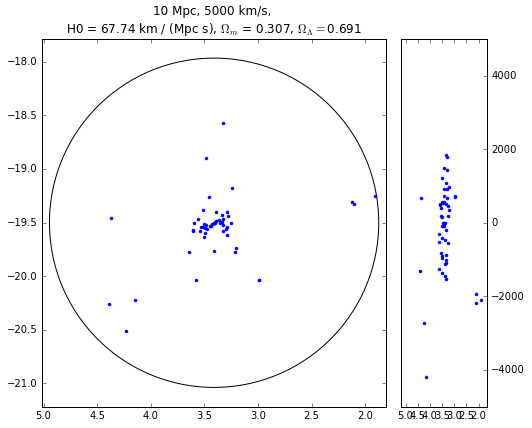

In [11]:
plot_env(ra, dec, res[1], res[0], title="10 Mpc, 5000 km/s, " 
            + "\nH0 = " + str(Planck15.H0)
            + ", $\Omega_{m}$ = " + str(Planck15.Om0)[:5]
            + ", $\Omega_{\Lambda} = $"+ str(Planck15.Ode0)[:5])

#### Comparison
<img src="http://ned.ipac.caltech.edu/results/env_plot_14743.png" style="width: 600px;"\ >

Yey!

## Iterate for some values
- same value used in the website ("Environmental Index" http://ned.ipac.caltech.edu/help/galenv/index.html)
- take a longer time due to re-download and re-plot ... ! repair it in script version

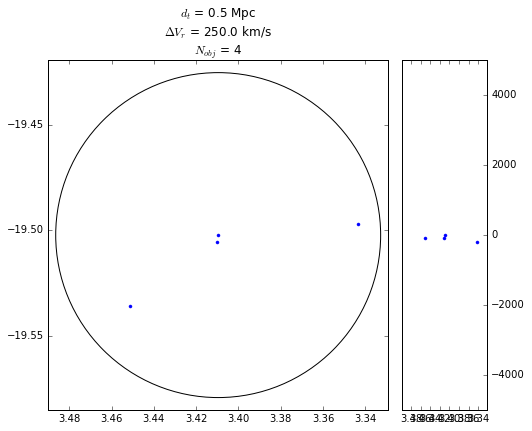

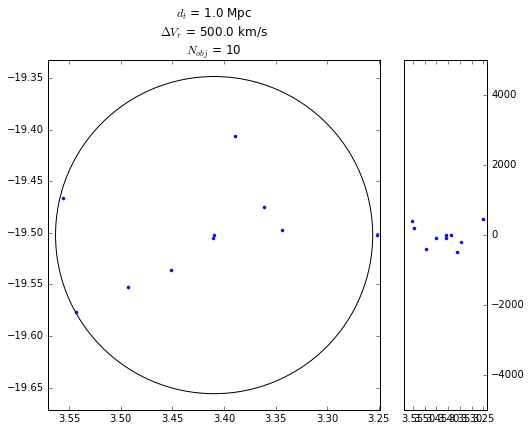

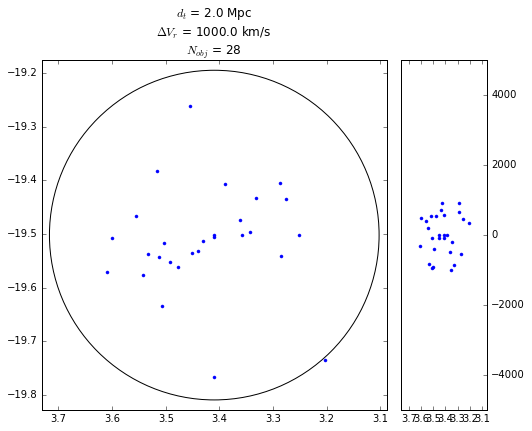

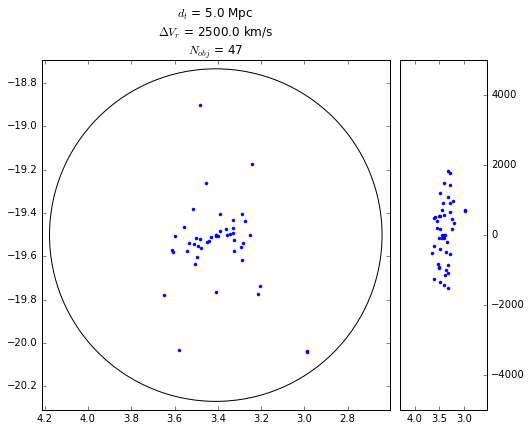

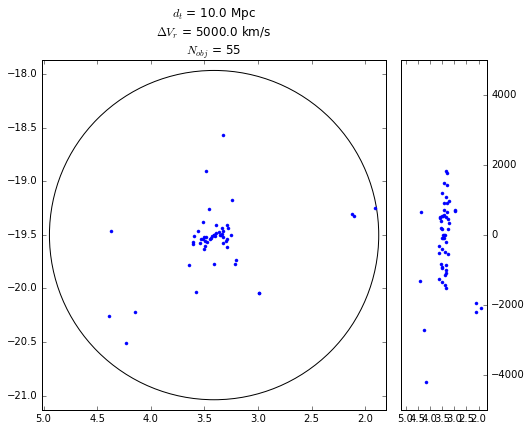

In [14]:
tangential_distance = [0.5, 1.0, 2.0, 5.0, 10.0] # Mpc
diff_radvel = [250.0, 500.0, 1000.0, 2500.0, 5000.0] # km/s

for i, td in enumerate(tangential_distance):
    res = searchobject_in_cone_dv(objname, z, v0, td*u.Mpc, diff_radvel[i])
    plot_env(ra, dec, res[1], res[0], title=r'$d_t$ = ' + str(td) + ' Mpc \n$\Delta V_r$ = ' 
                + str(diff_radvel[i]) + ' km/s \n$N_{obj}$ = ' + str(len(res[0])))